# Description

This notebook focuses on visualizing nodes within the Pywr-DRB model along with USGS gauge locations near those nodes.

In [55]:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely import ops
from shapely.geometry import Point, LineString, MultiLineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import folium
from folium.plugins import MarkerCluster
import contextily as cx
import sys

sys.path.append('../')
from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, obs_site_matches, nhm_site_matches


crs = 4386

# Data Preparation

Load the model nodes and edges from the `/model_data` folder. 

Create GeoDataFrame objects for each model component. These components include:

- Nodes:
    - Reservoirs (type = 'storage')
    - River gauges (type = 'rivergauge')
    - Model outputs (type = 'output')
    - Relevant USGS gauges 

- Edges:
    - Mainstem 
    - Tributaries
    - Diversions


In [2]:
### Load data, and usgs gauge data
node_geodata = pd.read_csv('./model_components/drb_model_major_nodes.csv', sep = ',')
all_usgs_gauges = pd.read_csv(f'./model_components/drb_usgs_gauges.csv', sep = ',')

### Load drb shapefiles
drb_boundary = gpd.read_file('DRB_shapefiles/drb_bnd_polygon.shp').to_crs(crs)
drb_river = gpd.read_file('DRB_shapefiles/delawareriver.shp').to_crs(crs)

# Reservoir data
reservoir_data = pd.read_csv('../pywrdrb/model_data/drb_model_istarf_conus.csv', sep = ',')

# Node catchments
node_basins = gpd.read_file('DRB_shapefiles/node_basin_geometries.shp').to_crs(crs)

# NHM Points of Interest
nhm_poi = pd.read_csv('./model_components/nhm_poi_ids.csv', sep =',', index_col=0)

# Filter drb gauges
all_gauges = gpd.GeoDataFrame(
    all_usgs_gauges.drop('geometry', axis = 1), geometry=gpd.points_from_xy(all_usgs_gauges.long, all_usgs_gauges.lat, crs = crs))
drb_gauges = gpd.clip(all_gauges, drb_boundary)

In [3]:
# Load the model
drb_model = json.load(open('../pywrdrb/model_data/drb_model_full_nhmv10.json'))
all_nodes = drb_model['nodes']
all_edges = drb_model['edges']

# Get all the available node type prefixes
all_node_types = []
for i in range(len(all_nodes)):
    all_node_types.append(all_nodes[i]['name'].split('_')[0])
all_node_types = list(set(all_node_types))

In [4]:
# Specify node and edge types to be plotted
plot_node_types = ['reservoir', 'delivery', 'link', 'outflow', 'output', 'delay']

# Filter for just types of interest
node_names = []
node_types = []
node_lat = []
node_long = []
node_descriptions = []
for i in range(len(all_nodes)):
    node_name = all_nodes[i]['name']
    if node_name.split('_')[0] in plot_node_types:
        node_names.append(node_name)
        node_types.append(all_nodes[i]['type'])
    
        for j, full_name in enumerate(node_geodata.name):
            if node_name == full_name:
                geodata_index = j
            elif node_name.split('_') == full_name.split('_'):
                geodata_index = j
            else:
                pass
            
        node_lat.append(node_geodata.lat.iloc[geodata_index])
        node_long.append(node_geodata.long.iloc[geodata_index])
        desc = node_geodata.description.iloc[geodata_index]
        if pd.isna(desc):
            node_descriptions.append(node_name)
        else:
            node_descriptions.append(desc)
            

nodes = pd.DataFrame({'name':node_names, 
                      'type':node_types, 
                      'lat':node_lat, 
                      'long':node_long,
                      'description': node_descriptions})

n_nodes = nodes.shape[0]

In [5]:
### Prepare edges
all_node1 = []
all_node2 = []
for i in range(len(all_edges)):
    if (all_edges[i][0] in nodes.name.values) and (all_edges[i][1] in nodes.name.values):
        all_node1.append(all_edges[i][0])
        all_node2.append(all_edges[i][1])

node1_coord = nodes.set_index('name').loc[all_node1][['lat','long']]
node2_coord = nodes.set_index('name').loc[all_node2][['lat','long']]

edges = pd.DataFrame({'node1': all_node1, 
         'node2': all_node2,
         'node1_lat': node1_coord.lat.values,
         'node1_long': node1_coord.long.values,
         'node2_lat': node2_coord.lat.values,
         'node2_long':node2_coord.long.values})

n_nodes = nodes.shape[0]
n_edges = edges.shape[0]

In [6]:
## Separate reservoirs for later color coding
nyc_main = ['reservoir_cannonsville', 'reservoir_neversink', 'reservoir_pepacton']
normal_supplemental = ['reservoir_blueMarsh', 'reservoir_beltzvilleCombined']
emergency = ['reservoir_wallenpaupack', 'reservoir_mongaupeCombined', 'reservoir_fewalter', 'reservoir_nockamixon', 'reservoir_prompton']
consumptive_makeup = ['reservoir_merrillCreek']
docket = ['reservoir_marshCreek']

regulated = nyc_main + normal_supplemental + emergency + consumptive_makeup + docket
all_reservoirs = nodes[nodes['type'] == 'storage'].name.to_list()

s = set(regulated)
unregulated = [x for x in all_reservoirs if x not in s]


# Geo-plotting

The `folium` package is used. 

See the documentation here: https://python-visualization.github.io/folium/

In [7]:
### PLot options
## Plot options
plot_gauges = True
plot_outputs = True
plot_catchments = True
plot_storage = True
plot_links = True
plot_reservoir_types = False  # Allows options to toggle reservoir color by regulation types
plot_nhm_hru = True

popup_width = 300

## Specify COLORS
# Link colors and dimensions
tributary_color = '#9fc5e8'
mainstem_color = '#397aa7'
diversion_color = '#f0b237'

tributary_weight = 4
mainstem_weight = 4
diversion_weight = 1

edge_opacity = 0.9
basin_opacity = 0.2

# Node colors
storage_colors = ["#505376", "#353856"]
gauge_colors = ['#78b72c', '#78b72c']
output_colors = ['#b72c78', '#b72c78']
catchment_colors = ["#3186cc", "#3186cc"]
link_colors = ['#5e5e5e', '#5e5e5e']

# Node dimensions
output_size  = 10
storage_size = 5
catchment_size = 30
link_size = 7

# Reservoir sizes
scale_reservoir_size = False
volume_scale = 1/15
max_radius = 25
min_radius = 10
fixed_reservoir_size = 15


# Fill opacity
fop = 0.9

In [8]:
# Initialize the map
start_coords = [40.7, -75]
geomap = folium.Map(location = start_coords, 
                    zoom_start = 7.35,
                   tiles = 'cartodbpositron',
                   control_scale = True)

# Start a feature group for toggle functionality
reservoir_layer = folium.FeatureGroup(name='Reservoirs', show=True)
output_layer = folium.FeatureGroup(name='Outputs & Diversions', show=True)
flow_target_layer = folium.FeatureGroup(name='DRBC Flow Target Locations', show=True)
gauge_layer = folium.FeatureGroup(name='USGS Gauges', show=False)
if plot_catchments:
    catchment_layer = folium.FeatureGroup(name='Reservoir Catchments', show=False)
basin_layer = folium.FeatureGroup(name='DRB Boundary', show=True)
if plot_nhm_hru:
    nhm_hru_layer = folium.FeatureGroup(name = 'NHM HRUs', show = False)

In [9]:
# DRB Boundary
for _, r in drb_boundary.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'none',
                                                    'weight': 1,
                                                    'color':'black', 
                                                    'opacity':1,
                                                     'fill_opacity': 0.8,
                                                    'fill': False})
    folium.Popup('Delaware River Basin Boundary', 
                 min_width = 200, 
                 max_width = 200).add_to(geo_j)
    geo_j.add_to(basin_layer)

# Mainstem River
for _, r in drb_river.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'none',
                                                    'weight': 1,
                                                    'color':'black', 
                                                    'opacity':1,
                                                    'fill': 'none'})
    folium.Popup('Delaware River Main Stem', 
                 min_width = 200, 
                 max_width = 200).add_to(geo_j)
    geo_j.add_to(basin_layer)

if plot_catchments:
    node_basins = node_basins.iloc[::-1]
    node_basins['area'] = node_basins.area

    def basin_colormap(area):
        if area > 0.9:
            return '#8ec2ed'
        elif area > 0.5:
            return '#376387'
        elif area > 0.1:
            return '#32857e'
        elif area < 0.1: 
            return '#1b6339'

    for _, r in node_basins.iterrows():
        node_name = r['node']
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                            style_function=lambda x: {'fillColor': basin_colormap(r['area']),
                                                        'weight': 1.0,
                                                        'color': storage_colors[0], 
                                                        'fillOpacity': basin_opacity,
                                                        'fill': True})
        folium.Popup(f'Catchment basin for {node_name}', 
                    min_width = 200, 
                    max_width = 200).add_to(geo_j)
        geo_j.add_to(catchment_layer)


/tmp/ipykernel_28194/1848305566.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_basins['area'] = node_basins.area


In [10]:
### Add ALL USGS Gauges
PLOT_ALL_USGS_GAGES= False

if PLOT_ALL_USGS_GAGES:
    for n in range(drb_gauges.shape[0]):
        coords = [drb_gauges.lat.iloc[n], drb_gauges.long.iloc[n]]
        
        disp = f'Gauge: 0{drb_gauges.site_id.iloc[n]} <br>Start: {drb_gauges.start_date.iloc[n]} <br>End: {drb_gauges.end_date.iloc[n]}'
        
        pop = folium.Popup(disp, min_width = popup_width, max_width = popup_width)
        
        folium.CircleMarker(coords, 
                                popup = pop,
                                fill_color = gauge_colors[1],
                                fill = True,
                                fill_opacity = 0.5,
                                radius = 3,
                                color = gauge_colors[0]).add_to(gauge_layer)

In [11]:
### Add USGS Gauges specific to Pywrdrb
for node, sites in obs_site_matches.items():
    if s:
        for s in sites:
            s_i = drb_gauges[drb_gauges.site_id == int(s[1:])].index
            
            if len(s_i)>0:
                coords = [drb_gauges.loc[s_i,'lat'], 
                        drb_gauges.loc[s_i,'long']]
        
                if s == node:
                    disp_text = f'Gauge {s} downstream of reservoir. <br>Start: {drb_gauges.loc[s_i,"start_date"]} <br>End: {drb_gauges.loc[s_i, "end_date"]}'
                else:
                    disp_text = f'Inflow gauge for {node.capitalize()}: {s} <br>Start: {drb_gauges.loc[s_i,"start_date"]} <br>End: {drb_gauges.loc[s_i, "end_date"]}'
                    
                
                pop = folium.Popup(disp_text, min_width = popup_width, max_width = popup_width)
                
                folium.CircleMarker(coords, 
                                        popup = pop,
                                        fill_color = gauge_colors[1],
                                        fill = True,
                                        fill_opacity = 1.0,
                                        radius = 5,
                                        color = gauge_colors[0]).add_to(gauge_layer)

/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float

/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]
/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/folium/utilities.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float

In [12]:
## Plot edges
for l in range(n_edges):
    coord_1 = [edges['node1_lat'][l], edges['node1_long'][l]]
    coord_2 = [edges['node2_lat'][l], edges['node2_long'][l]]
    line = [coord_1, coord_2]
    
    folium.PolyLine(line, 
                       weight = tributary_weight,
                       color = tributary_color,
                       opacity = edge_opacity).add_to(geomap)

In [13]:
# Add nodes
for n in range(n_nodes):
    coords = [nodes.lat.iloc[n], nodes.long.iloc[n]]
    
    disp = nodes['description'].iloc[n]
    if pd.isna(disp):
        disp = nodes.name[n]
    
    node_type = nodes.type[n]
    name = nodes.name[n]
    
    pop = folium.Popup(disp, min_width = popup_width, max_width = popup_width)
        
    if node_type == 'storage':
        
        res_name = nodes.name.iloc[n].split('_')[1]
        volume = reservoir_data[reservoir_data['reservoir'] == res_name]['GRanD_CAP_MCM'].iloc[0]
        if scale_reservoir_size:
            if (volume*volume_scale > max_radius):
                s = max_radius
            elif (volume*volume_scale < min_radius):
                s = min_radius
            else:
                s = volume*volume_scale
        else:
            s = fixed_reservoir_size
            
        pop = folium.Popup(f'{disp} <br> Capacity: {volume} MCM', min_width = popup_width, max_width = popup_width)


        folium.RegularPolygonMarker(coords,
                                   popup = pop,
                                   number_of_sides = 8,
                                   radius = s,
                                    weight = 0.75,
                                   fill_color = storage_colors[1],
                                   fill_opacity = fop,
                                   color = storage_colors[0],
                                   rotation = 90).add_to(reservoir_layer)
        
    elif node_type == 'rivergauge':
        if name == 'outflow_delTrenton':
            folium.Marker(coords, 
                        popup = pop,
                        icon=folium.Icon(color="green"),
                        radius =100).add_to(flow_target_layer)
        elif name == 'outflow_delMontague':
            folium.Marker(coords, 
                        popup = pop,
                        icon=folium.Icon(color="purple"),
                        radius =60).add_to(flow_target_layer)
                
    elif node_type == 'output':
        if plot_outputs:
            if name == 'output_del':
                c = '#EAC100'
            else:
                c = output_colors[1]
            folium.RegularPolygonMarker(coords,
                                       popup = pop,
                                       number_of_sides = 4, 
                                       radius = output_size,
                                       fill_color= c,
                                        fill_opacity = fop,
                                       color = c).add_to(output_layer)
        
    elif node_type == 'link':
        
        if plot_links:
            if name.split('_')[0] != 'outflow':
                folium.CircleMarker(coords, 
                                    popup = pop,
                                    fill_color = link_colors[1],
                                    fill = True,
                                    fill_opacity = 0.5,
                                    color = link_colors[0],
                                radius = link_size).add_to(geomap)
        else:
            pass

In [14]:
# Add NHM HRUs/Points of Interest
if plot_nhm_hru:
    
    for i in range(nhm_poi.shape[0]):
        coords = [nhm_poi.lat[i], nhm_poi.long[i]]
        disp = f'COMID: {nhm_poi.comid[i]}<br>NHM ID: {nhm_poi.nhm_id[i]}'
        pop = folium.Popup(disp, min_width = popup_width, max_width = popup_width)
    
        folium.CircleMarker(coords, 
                        popup = pop,
                        fill_color = 'purple',
                        fill = True,
                        fill_opacity = fop,
                        radius = 3,
                        color = 'purple').add_to(nhm_hru_layer)

In [15]:
## Add reservoir layers based on regulation level
if plot_reservoir_types:
    nyc_reservoir_layer = folium.FeatureGroup(name='NYC', show=False)
    normal_reservoir_layer = folium.FeatureGroup(name='Normal Non-NYC', show=False)
    emergency_reservoir_layer = folium.FeatureGroup(name='Emergency', show=False)
    docket_reservoir_layer = folium.FeatureGroup(name='Docket', show=False)
    consumptive_makeup_reservoir_layer = folium.FeatureGroup(name='Consumptive Make-Up', show=False)

    ## Color codes
    nyc_main_color = '#3D9F2A'
    normal_supplemental_color = '#03D19C'
    emergency_color = '#E38B14'
    consumptive_makeup_color = '#6E6E6E'
    docket_color = '#FFEB90'
    unregulated_color = '#A4A4A4'

    s2_opacity = 0.9

    # Add nodes
    for n in range(n_nodes):
        coords = [nodes.lat.iloc[n], nodes.long.iloc[n]]
        
        disp = nodes['description'].iloc[n]
        if pd.isna(disp):
            disp = nodes.name[n]
        
        node_type = nodes.type[n]
        name = nodes.name[n]
        
        pop = folium.Popup(disp, min_width = popup_width, max_width = popup_width)
            
        if node_type == 'storage':
            
            res_name = nodes.name.iloc[n].split('_')[1]
            volume = reservoir_data[reservoir_data['reservoir'] == res_name]['GRanD_CAP_MCM'].iloc[0]
            if scale_reservoir_size:
                if (volume*volume_scale > max_radius):
                    s = max_radius
                elif (volume*volume_scale < min_radius):
                    s = min_radius
                else:
                    s = volume*volume_scale
            else:
                s = fixed_reservoir_size

            pop = folium.Popup(f'{disp} <br> Capacity: {volume} MCM', min_width = popup_width, max_width = popup_width)
            
            if name in nyc_main:
                folium.RegularPolygonMarker(coords,
                                        popup = pop,
                                        number_of_sides = 8,
                                        radius = s,
                                        fill_color = nyc_main_color,
                                        fill_opacity = s2_opacity,
                                        color = nyc_main_color,
                                        rotation = 90).add_to(nyc_reservoir_layer)
            elif name in normal_supplemental:
                folium.RegularPolygonMarker(coords,
                                        popup = pop,
                                        number_of_sides = 8,
                                        radius = s,
                                        fill_color = normal_supplemental_color,
                                        fill_opacity = s2_opacity,
                                        color = normal_supplemental_color,
                                        rotation = 90).add_to(normal_reservoir_layer)

            elif name in emergency:
                folium.RegularPolygonMarker(coords,
                                        popup = pop,
                                        number_of_sides = 8,
                                        radius = s,
                                        fill_color = emergency_color,
                                        fill_opacity = s2_opacity,
                                        color = emergency_color,
                                        rotation = 90).add_to(emergency_reservoir_layer)
            elif name in docket:
                folium.RegularPolygonMarker(coords,
                                        popup = pop,
                                        number_of_sides = 8,
                                        radius = s,
                                        fill_color = docket_color,
                                        fill_opacity = s2_opacity,
                                        color = docket_color,
                                        rotation = 90).add_to(docket_reservoir_layer)

            elif name in consumptive_makeup:
                folium.RegularPolygonMarker(coords,
                                        popup = pop,
                                        number_of_sides = 8,
                                        radius = s,
                                        fill_color = consumptive_makeup_color,
                                        fill_opacity = s2_opacity,
                                        color = consumptive_makeup_color,
                                        rotation = 90).add_to(consumptive_makeup_reservoir_layer)

            else:
                pass

In [16]:
# Display the map
basin_layer.add_to(geomap)
gauge_layer.add_to(geomap)
reservoir_layer.add_to(geomap)
output_layer.add_to(geomap)
flow_target_layer.add_to(geomap)

if plot_nhm_hru:
    nhm_hru_layer.add_to(geomap)

if plot_catchments:
    catchment_layer.add_to(geomap)

if plot_reservoir_types:
    nyc_reservoir_layer.add_to(geomap)
    normal_reservoir_layer.add_to(geomap)
    emergency_reservoir_layer.add_to(geomap)
    docket_reservoir_layer.add_to(geomap)
    consumptive_makeup_reservoir_layer.add_to(geomap)

folium.LayerControl().add_to(geomap)
geomap.keep_in_front(reservoir_layer)
geomap.save("drb_model_map.html")
geomap

### Static map for paper

In [17]:
drb_river.loc[drb_river['TYPE']=='water']

,TYPE,NAME,SQMI,Shape_Leng,Shape_Area,geometry
0,water,Delaware River,50.9,1.191433e+06,1.325023e+08,"POLYGON ((-75.30195 41.94796, -75.30283 41.947..."
142,water,None,0.0,1.193835e+03,7.391872e+04,"POLYGON ((-74.76000 40.13642, -74.76034 40.136..."


<Axes: >

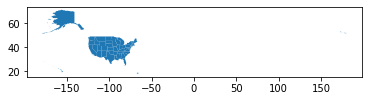

In [18]:
states = gpd.read_file('states/tl_2010_us_state10.shp')
states.plot()

In [19]:
nhd = gpd.read_file('../DRB_spatial/NHD_0204/Shape/NHDFlowline.shp').to_crs(crs)
# nhd.plot()

In [20]:
nhd.head()

,permanent_,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbarea_per,ftype,fcode,mainpath,innetwork,visibility,SHAPE_Leng,ObjectID,geometry
0,26277785,2012-03-08,2,None,None,0.045000,02040106003573,1,None,460,46006,0,1,100000,None,1,"LINESTRING Z (-75.50473 41.24608 0.00000, -75...."
1,{1AA206A6-5F7E-4627-ADAD-AFE0A1B92BF2},2017-11-07,2,2787101,Feldspar Run,0.440751,02040205007004,1,None,460,46006,0,1,24000,None,2,"LINESTRING Z (-75.71275 39.91155 0.00000, -75...."
2,{76813392-3D9C-49E7-9E05-71FE9C2A580F},2017-11-07,2,02787100,Corundum Run,0.198642,02040205003157,1,None,460,46006,0,1,24000,None,3,"LINESTRING Z (-75.71534 39.91377 0.00000, -75...."
3,167289687,2021-12-29,2,00876861,Hatchery Brook,0.019000,02040105011939,1,None,334,33400,0,1,100000,None,4,"LINESTRING Z (-74.83992 40.86051 0.00000, -74...."
4,100545062,2021-12-29,2,00878064,Manapaqua Brook,0.170000,02040301007364,1,None,460,46006,0,1,250000,None,5,"LINESTRING Z (-74.34158 40.02145 0.00000, -74...."


In [21]:
major_nodes = gpd.read_file('./model_components/drb_model_major_nodes.csv', sep = ',')
reservoirs = major_nodes.loc[major_nodes['type'] == 'reservoir']
reservoirs = gpd.GeoDataFrame(reservoirs.drop('geometry', axis = 1), 
                              geometry=gpd.points_from_xy(reservoirs.long, reservoirs.lat, crs = crs))

flow_reqs = major_nodes.loc[major_nodes['type'] == 'regulatory']
flow_reqs = gpd.GeoDataFrame(flow_reqs.drop('geometry', axis = 1), 
                              geometry=gpd.points_from_xy(flow_reqs.long, flow_reqs.lat, crs = crs))



In [22]:
### read in NJ NHD shapefile, which is too big for repo. then pull out just Delaware and Raritan Canal and save it in repo.
# nj = gpd.read_file('../../NHD_NJ/Shape/NHDFlowline.shp')
# drc = nj.loc[nj['gnis_name'] == 'Delaware and Raritan Canal']
# drc.to_file('NHD_NJ/DRCanal.shp')

### once we ran above, we can just read in DRC directly
drc = gpd.read_file('NHD_NJ/DRCanal.shp')

In [64]:
### set crs consistent with contextily basemap
crs = 'EPSG:3857' 
states = states.to_crs(crs)
drb_boundary = drb_boundary.to_crs(crs)
reservoirs = reservoirs.to_crs(crs)
flow_reqs = flow_reqs.to_crs(crs)
drc = drc.to_crs(crs)

### get river network from NHD
nhd = nhd.to_crs(crs)
mainstem = nhd.loc[nhd['gnis_name'] == 'Delaware River']
## for river/stream objects, merge rows into single geometry to avoid white space on plot
multi_linestring = MultiLineString([ls for ls in mainstem['geometry'].values])
merged_linestring = ops.linemerge(multi_linestring)
mainstem = gpd.GeoDataFrame({'geometry': [merged_linestring]})

### get all other tributary streams containing a Pywr-DRB reservoir, or downstream of one. Note that 2 different regions have Tulpehocken Creek - use only the correct one.
trib_names = ['West Branch Delaware River', 'East Branch Delaware River', 'Neversink River', 
               'Mongaup River', 'Lackawaxen River', 'West Branch Lackawaxen River', 'Wallenpaupack Creek', 
               'Lehigh River', 'Shohola Creek', 'Pohopoco Creek', 'Merrill Creek', 'Musconetcong River', 
               'Pohatcong Creek', 'Tohickon Creek', 'Assunpink Creek', 'Schuylkill River', 'Maiden Creek',
               'Tulpehocken Creek', 'Still Creek', 'Little Schuylkill River', 'Perkiomen Creek']#, 'Delaware and Raritan Canal']
tribs = []
for trib_name in trib_names:
    trib = nhd.loc[[(n == trib_name) and ((n != 'Tulpehocken Creek') or ('02040203' in c)) for n,c in zip(nhd['gnis_name'], nhd['reachcode'])]]
    multi_linestring = MultiLineString([ls for ls in trib['geometry'].values])
    merged_linestring = ops.linemerge(multi_linestring)
    trib = gpd.GeoDataFrame({'geometry': [merged_linestring], 'name': trib_name})
    tribs.append(trib)



In [65]:
### lines for NYC tunnel systems
### cannonsville to rondout
lines = [LineString([Point(-75.37462, 42.065872), Point(-74.4296, 41.79926)])]
### pepacton to rondout
lines.append(LineString([Point(-74.965531, 42.073603), Point(-74.4296, 41.79926)]))
### neversink to rondout
lines.append(LineString([Point(-74.643266, 41.821286), Point(-74.4296, 41.79926)]))
### rondout to west branch reservoir
lines.append(LineString([Point(-74.4296, 41.79926), Point(-73.69541, 41.41176)]))
### west branch reservoir to kensico reservoir
lines.append(LineString([Point(-73.69541, 41.41176), Point(-73.7659656, 41.0737078)]))
### kensico reservoir to hillside reservoir
lines.append(LineString([Point(-73.7659656, 41.0737078), Point(-73.8693806, 40.90715556)]))

### convert projection
aqueducts = gpd.GeoDataFrame({'geometry': lines}, crs='EPSG:4326')
aqueducts = aqueducts.to_crs(crs)


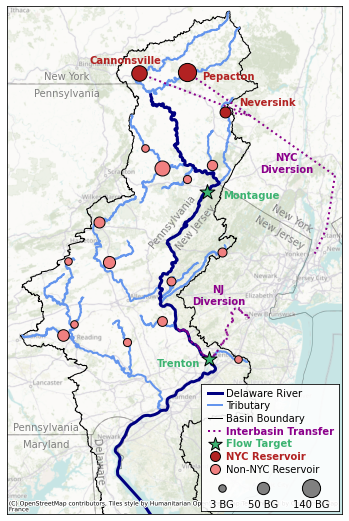

In [66]:
use_basemap = True

fig, ax = plt.subplots(1,1,figsize=(6,10))

### drb boundary
drb_boundary.plot(ax=ax, color='none', edgecolor='k', lw=1, zorder=0.9)

### plot river network
mainstem.plot(ax=ax, color='navy', lw=3, zorder=1.1)
for trib in tribs:
    trib.plot(ax=ax, color='cornflowerblue', lw=2, zorder=1)



### plot reservoirs & min flow locations
list_nyc_reservoirs = ('reservoir_cannonsville','reservoir_pepacton','reservoir_neversink')
for r in reservoirs['name']:
    color = 'firebrick' if r in list_nyc_reservoirs else 'lightcoral'
    r_abbrev = r.split('_')[1]
    try:
        s = 50 + reservoir_data['Adjusted_CAP_MG'].loc[reservoir_data['reservoir'] == r_abbrev].iloc[0]/1000*2
    except:
        s = 50
    reservoirs.loc[reservoirs['name'] == r].plot(ax=ax, color=color, edgecolor='k', markersize=s, zorder=2)
flow_reqs.plot(ax=ax, color='mediumseagreen', edgecolor='k', markersize=250, zorder=2.1, marker='*')

### NYC tunnel systsem
aqueducts.plot(ax=ax, color='darkmagenta', lw=2, zorder=1.2, ls=':')

### plot NJ diversion - Delaware & Raritan Canal
drc.plot(ax=ax, color='darkmagenta', lw=2, zorder=1.2, ls=':')

### add state boundaries
if use_basemap:
    states.plot(ax=ax, color='none', edgecolor='0.5', lw=0.7, zorder = 0)
else:
    states.plot(ax=ax, color='0.95', edgecolor='0.5', lw=0.7, zorder = 0)    
    
### map limits etc
ax.set_xlim([-8.517e6,-8.197e6])# -8.215e6])
ax.set_ylim([4.75e6, 5.235e6])

### annotations
fontsize=10
fontcolor = '0.5'
plt.annotate('New York', xy=(-8.46e6, 5.168e6), ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('Pennsylvania', xy=(-8.46e6, 5.152e6), ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('New York', xy=(-8.245e6, 5.032e6), rotation=-31, ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('New Jersey', xy=(-8.257e6, 5.019e6), rotation=-31, ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('Pennsylvania', xy=(-8.48e6, 4.833e6), ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('Maryland', xy=(-8.48e6, 4.817e6), ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('Delaware', xy=(-8.43e6, 4.8e6), rotation=-85, ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('Pennsylvania', xy=(-8.359e6, 5.03e6), rotation=50, ha='center', va='center', fontsize=fontsize, color=fontcolor)
plt.annotate('New Jersey', xy=(-8.337e6, 5.024e6), rotation=50, ha='center', va='center', fontsize=fontsize, color=fontcolor)

fontcolor = 'firebrick'
plt.annotate('Cannonsville', xy=(-8.404e6, 5.1835e6),ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')
plt.annotate('Pepacton', xy=(-8.306e6, 5.168e6), ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')
plt.annotate('Neversink', xy=(-8.268e6, 5.143e6), ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')
fontcolor = 'mediumseagreen'
plt.annotate('Montague', xy=(-8.284e6, 5.055e6),ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')
plt.annotate('Trenton', xy=(-8.353e6, 4.894e6),ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')
fontcolor = 'darkmagenta'
plt.annotate('NYC\nDiversion', xy=(-8.25e6, 5.085e6),ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')
plt.annotate('NJ\nDiversion', xy=(-8.315e6, 4.959e6),ha='center', va='center', fontsize=fontsize, color=fontcolor, fontweight='bold')


### legend
axin = ax.inset_axes([0.58, 0.006, 0.41, 0.25])
axin.set_xlim([0,1])
axin.set_ylim([0,1])
### mainstem
axin.plot([0.05, 0.15], [0.93, 0.93], color='navy', lw=3)
axin.annotate('Delaware River', xy=(0.18, 0.93), ha='left', va='center', color='k', fontsize=fontsize)
### tributaries
axin.plot([0.05, 0.15], [0.83, 0.83], color='cornflowerblue', lw=2)
axin.annotate('Tributary', xy=(0.18, 0.83), ha='left', va='center', color='k', fontsize=fontsize)
### DRB boundary
axin.plot([0.05, 0.15], [0.73, 0.73], color='k', lw=1)
axin.annotate('Basin Boundary', xy=(0.18, 0.73), ha='left', va='center', color='k', fontsize=fontsize)
### Diversions
axin.plot([0.05, 0.15], [0.63, 0.63], color='darkmagenta', lw=2, ls=':')
axin.annotate('Interbasin Transfer', xy=(0.18, 0.63), ha='left', va='center', color='darkmagenta', fontweight='bold', fontsize=fontsize)
### Minimum flow targets
axin.scatter([0.1], [0.53], color='mediumseagreen', edgecolor='k', s=200, marker='*')
axin.annotate('Flow Target', xy=(0.18, 0.53), ha='left', va='center', color='mediumseagreen', fontweight='bold', fontsize=fontsize)
### NYC Reservoirs
axin.scatter([0.1], [0.43], color='firebrick', edgecolor='k', s=100)
axin.annotate('NYC Reservoir', xy=(0.18, 0.43), ha='left', va='center', color='firebrick', fontweight='bold', fontsize=fontsize)
### Non-NYC Reservoirs
axin.scatter([0.1], [0.33], color='lightcoral', edgecolor='k', s=100)
axin.annotate('Non-NYC Reservoir', xy=(0.18, 0.33), ha='left', va='center', color='k', fontsize=fontsize)
### marker size for reservoirs
# axin.annotate('Reservoir Capacity', xy=(0.05, 0.3), ha='left', va='center', color='k', fontsize=fontsize)
axin.scatter([0.15], [0.18], color='0.5', edgecolor='k', s=50 + 3000/1000*2)
axin.scatter([0.45], [0.18], color='0.5', edgecolor='k', s=50 + 50000/1000*2)
axin.scatter([0.8], [0.18], color='0.5', edgecolor='k', s=50 + 140000/1000*2)
axin.annotate('3 BG', xy=(0.15, 0.05), ha='center', va='center', color='k', fontsize=fontsize)
axin.annotate('50 BG', xy=(0.45, 0.05), ha='center', va='center', color='k', fontsize=fontsize)
axin.annotate('140 BG', xy=(0.8, 0.05), ha='center', va='center', color='k', fontsize=fontsize)
### clean up
axin.set_xticks([])
axin.set_yticks([])
axin.patch.set_alpha(0.9)

# ### basemap - this is slow and breaks sometimes, if so just try later
if use_basemap:
    cx.add_basemap(ax=ax, alpha=0.5, attribution_size=6)
    figname = 'static_map_withbasemap.png'
else:
    figname = 'static_map.png'
    
ax.set_xticks([])
ax.set_yticks([])


plt.savefig(figname, bbox_inches='tight', dpi=300)